## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. Cells in which "# YOUR CODE HERE" is found are the cells where your graded code should be written.
2. In order to test out or debug your code you may also create notebook cells or edit existing notebook cells other than "# YOUR CODE HERE". We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Deep Learning - Convolutional Neural Networks

In this exercise we'll compare a simple fully-connected (dense) feedforward neural network with a convolutional neural network at predicting the [MNIST handwritten digits, drawn in a 28x28 pixel image](http://yann.lecun.com/exdb/mnist/). 

Note that each sample we're using is a grayscale image - that means that each sample (image) is a matrix of values whereas previously our samples had been vectors. You will need to modify the data to work with this accordingly. For example, keras' [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers expect their inputs to be vectors so whenever you're using a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer, make sure you convert its inputs to a vector, if needed. In keras, you can convert a matrix (or tensor) to a vector using the [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer. For more complex changes where you want to cusomize the exact shape of the values, you can use the [Reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) layer.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Softmax
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
s1 = x_train.shape
s2 = x_test.shape
print(f"The MNIST data was loaded with {s1[0]} training samples and {s2[0]} testing samples.")
print(f"Each sample is a {s1[1]} x {s1[2]} pixel image.")

The MNIST data was loaded with 60000 training samples and 10000 testing samples.
Each sample is a 28 x 28 pixel image.


In [4]:
# Here's an example hand drawn digit's image
example = x_train[0]
example

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

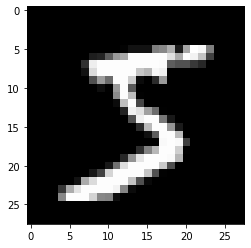

In [5]:
# Now let's plot that matrix to better understand what's happening here...
_ = plt.imshow(example, cmap="gray")

In [6]:
# In this cell, we'll print out the unique labels in the data.
#
# We're predicting the digit in an image and we have images of
# all 10 ('0' to '9') digits.

print(np.unique(y_test))

[0 1 2 3 4 5 6 7 8 9]


### Convolutions

Most engineers in computer scientists are familiar with convolutions. If you're not, or you need a refresher, try [this article on discrete convolutions](https://electricalacademia.com/signals-and-systems/example-of-discrete-time-graphical-convolution/). The article is on discrete *time* convolutions, but the process is the same for discrete *spatial* convolutions--which is what we are doing when we perform a 2D convolution on an image.

To check your basic understanding of convolutions, implement the function below, which computes what the output image shape will be for a given convolutional kernel (filter) applied to a given input image. Recall that for a given dimension, the length of the output of a convolution is:

`L_out = L_in - L_kernel + 1`

where L_in is the length of the input (pixels), L_kernel is the length of the filter/kernel, and L_out is the length of the output (pixels)

The equation above assumes that we haven't added any "padding" to the input image, e.g., pixels of value 0 that we use to extend/enlarge the input image. In Keras, you'll see that a user can specify padding as a scalar number of pixels to add __to each side of the image__. Thus,

`L_in_padded = L_in + 2*padding`  
`L_out = L_in_padded - L_kernel + 1`  
`L_out = L_in + 2*padding - L_kernel + 1`  

Finally, we may want to use a convolution in which the kernel doesn't "slide" along the input in single-pixel steps, but in multiple-pixel steps, of step size `stride`. You may want to diagram it out for yourself on a piece of paper (in a manner like that of the article linked above), but we effectively just need to divide the output length by the stride value (before adding the 1) to get strided output size. Because it may be fractional, the final answer is actually the floor of that previous result. This gives us...

`L_out = floor( (L_in + 2*padding - L_kernel) / stride + 1 )`

In the function below, you'll need to implement that equation separately for the horizontal and vertical dimensions of the image and kernel. Do not assume that either the image or the kernel are square. In Python, `int()` converts a number to an integer, executing a floor operation if the number is floating-point.

In [7]:
def calculate_conv_shape(X, K, padding=0, stride=1):
    """Calculate the shape of the output of a convolution 
    
    Args:
        X (np.array): The input matrix
        K (np.array): The filter matrix
        padding (int, optional): Defaults to 0. The padding dimension
        stride (int, optional): Defaults to 1. The stride of the convolution
    
    Returns:
        tuple: The shape of the convolution output, height then width
    """
    # YOUR CODE HERE
    L_in = len(X)
    L_kernel = len(K)
    L_out = np.floor((L_in + 2*padding - L_kernel) / stride + 1 )
    output = (int(L_out), int(L_out))
    return output

In [8]:
# Here, we define a "blurring" filter/kernel, that can be applied
# to an image to get a blurred output image.

blur = np.array([
    [0,    0.25, 0   ],
    [0.25, 0.5,  0.25],
    [0,    0.25, 0   ]
])

# If we pad our 28x28 example image and then convolve it
# with the blurring kernel (with stride=1), the output
# image should also be 28x28.
calculate_conv_shape(example, blur, padding=1)

(28, 28)

In [9]:
ans = calculate_conv_shape(example, blur, padding=1)
assert isinstance(ans, tuple)
assert isinstance(ans[0], int)
assert isinstance(ans[1], int)
assert ans == (28, 28)
ans = calculate_conv_shape(example, blur, padding=0, stride=2)
assert ans == (13, 13)

### Try out a convolution

To apply a convolution, you can use the [scipy.ndimage.convolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html). `scipy` has already been imported for you above.

Convert `example` to floating point numbers using `example.astype(np.float)` before you execute the convolution.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


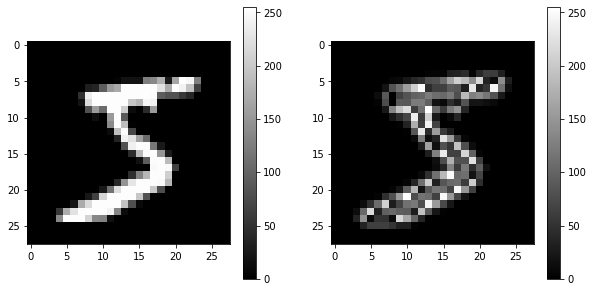

In [10]:
# Apply the blurring filter to the example and save the output to "blurred_image".
#
# Be sure to convert the example from unsigned int numbers to floating-point numbers
# beforehand.

# YOUR CODE HERE
example.astype(np.float)
blurred_image = scipy.ndimage.convolve(example, blur)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(example, cmap="gray")
plt.colorbar()
           
plt.subplot(1, 2, 2)
plt.imshow(blurred_image, cmap="gray")
_ = plt.colorbar()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


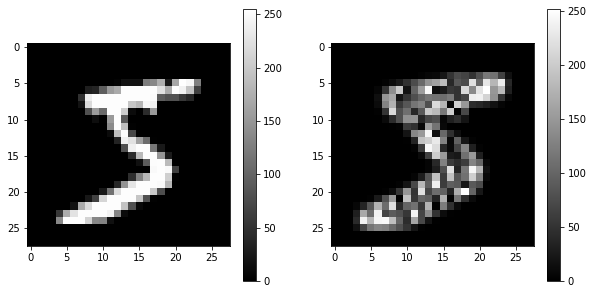

In [11]:
# Create a 3x3 filter of your choice (a matrix of numbers) and save it as "my_filter".
#
# Then apply that filter to the example and save the output image as "filtered_image".
#
# Again, be sure to convert the example from unsigned int numbers to floating-point
# numbers beforehand.

# YOUR CODE HERE
my_filter = np.array([
    [0.13, 0.26, 0.13   ],
    [0.26, 1,  0.26],
    [0.13,  0.26,  0.13]
])
example.astype(np.float)
filtered_image = scipy.ndimage.convolve(example, my_filter)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(example, cmap="gray")
plt.colorbar()
           
plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap="gray")
_ = plt.colorbar()

In [12]:
assert blurred_image.shape == example.shape
assert filtered_image.shape == example.shape
assert my_filter.shape == (3,3)

### Feedforward NN versus CNN

Let's build two models -- a dense feed-forward NN and a convolutional NN. We'll train each on the MNIST training set, test them on the test set, and compare performance results (accuracy). Because the test data set is balanced (approximately 1000 samples of each of the 10 digits), accuracy is a reasonably good metric so we'll just use that rather than F-score, for simplicity.

In an effort have an apples-to-apples comparison, we'll use the same number of layers in both networks, and nearly the same number of total model parameters.

__We'll start by creating a the feedforward network--one with two hidden layers plus an output layer.__

In [13]:
# Create a list of Keras layers, calling it "ff_layers", and use the
# Keras Sequential class to create a feedforward NN model, as you
# did in Activity 5a.
#
# Your model should have two hidden Dense layers and an output Dense layer.
#
# Use the "relu" activation function for the hidden layers. Other point-wise
# non-linear activation function might work fairly well, but ReLU is the
# most common because of its computational efficiency as well as its
# effectiveness.
#
# Use 25 neurons in each of the hidden layers.
#
# This is a classification task with 10 output classes so select the output
# layer's activation function accordingly. Review the reading material or lecture
# slides from the first deep learning lecture, 5a, if you don't recall
# what it should be or why.
#
# Since the input data (image) is a matrix, you'll need to additional layers
# at the beginning of your "ff_layers" list.
# 1. An Input() layer, that tells the model what shape the input samples
#    will be, (28, 28, 1).
# 2. A Flatten layer, to convert that image/matrix into a vector, which
#    is the what the subsequent Dense layer expects.
#
# Also, add a Dropout layer after each hidden Dense layer, for regularization.
#
# Finally, save the resulting Sequential model as "ff_model"

# YOUR CODE HERE

ff_layers = [Input((28,28,1)), 
             Flatten(),
             Dense(25, activation='relu', name = 'layer1'),
             Dropout(0.2),
             Dense(25, activation='relu', name = 'layer2'),
             Dropout(0.2),
             Dense(10, activation='softmax', name = 'layer3')]
ff_model = tf.keras.Sequential(ff_layers)


ff_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 25)                19625     
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 layer2 (Dense)              (None, 25)                650       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 layer3 (Dense)              (None, 10)                260       
                                                                 
Total params: 20,535
Trainable params: 20,535
Non-traina

Look at the output __above__, from `ff_model.summary()`, and take note of the __total number of model parameters__.

In [14]:
assert len(ff_layers) == 7
target_type = [Flatten, Dense, Dropout, Dense, Dropout, Dense]
for l, tt in zip(ff_model.layers, target_type):
    assert isinstance(l, tt)

### Evaluating your test or validation set while training

In previous notebooks we passed our training data to `Model.fit`, which trained for a specified number of epochs. Then we plotted the training set loss (and/or metrics) as a function of epochs, allowing us to see the dynamics of the model's convergence toward a solution.

In this notebook we'll also pass our test data to `Model.fit`. The Model object is smart. It will use only the training data for fitting, but it will also compute the loss and metric functions for the test data, at the end of each training epoch. Afterwards, we can plot the loss and metrics for both the training data and for the test data.

Epoch 1/20
1875/1875 [==============================] - 11s 5ms/step - loss: 2.6822 - accuracy: 0.1903 - val_loss: 1.9752 - val_accuracy: 0.2303
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.9601 - accuracy: 0.2489 - val_loss: 1.8186 - val_accuracy: 0.2869
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.8442 - accuracy: 0.2864 - val_loss: 1.6580 - val_accuracy: 0.3538
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.7322 - accuracy: 0.3332 - val_loss: 1.4793 - val_accuracy: 0.4536
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.5497 - accuracy: 0.4315 - val_loss: 1.1732 - val_accuracy: 0.5710
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.3857 - accuracy: 0.4833 - val_loss: 1.0703 - val_accuracy: 0.6011
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.2991 - accuracy: 0.5338 - val_loss: 0.9251 - val_accuracy

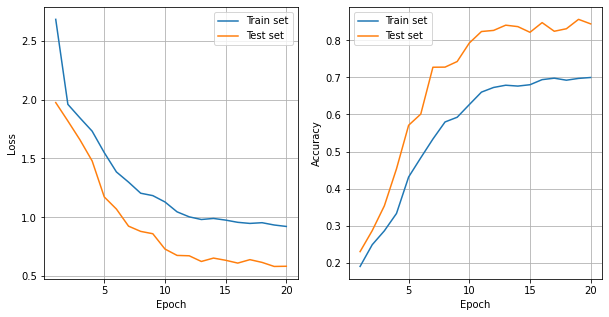

In [15]:
## Let's train the model and plot the training loss curve
#
# We'll train for 20 epochs. If you change model parameters/hyperparameters above,
# and the model's loss curve hasn't flattened (approximately) after 20 epochs, you
# can increase the number of training epochs.

ff_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
n_epochs = 20
history = ff_model.fit(x_train, y_train, epochs=n_epochs, validation_data=(x_test, y_test))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_epochs+1), history.history['loss'], label='Train set')
plt.plot(np.arange(1, n_epochs+1), history.history['val_loss'], label='Test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, n_epochs+1), history.history['accuracy'], label='Train set')
plt.plot(np.arange(1, n_epochs+1), history.history['val_accuracy'], label='Test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

print(f"\nAccuracy on the final epoch of training was {100*history.history['accuracy'][-1]:0.2f}%")

In [16]:
# Let's assess our FF model's performance on the test set
ff_scores = ff_model.evaluate(x_test, y_test)

print(f"\nThe fully-connected feedforward model achieves an accuracy of {ff_scores[1]*100:.2f}% on the test data.")

313/313 [==============================] - 1s 2ms/step - loss: 0.5842 - accuracy: 0.8443

The fully-connected feedforward model achieves an accuracy of 84.43% on the test data.


### Result from the feedforward NN

__You may find that the accuracy on the test set is higher than reported for the training set! But it's really not. Let us explain...__

We used dropout during training, which helps with model regularization (and generalization) but reduces performance when in use (i.e., during training). __When we use the `evaluate()` method, the dropout layers are "turned off."__ Similarly, `fit` does not apply dropout to the test/validation set, only to the training set. If we were to put our training set through the trained model, without dropout (that is, by using `evaluate`) we would get accuracy scores like those of the test data, and likely a little bit higher.

What's a good accuracy for our model? Is 50% good? 

Something to consider is that we have 10 classes - does that change your answer? What would random guessing's accuracy be? 

Based on your answer to the above questions, is your simple model good? 

__Let's see if we can do better. In the next section, we'll build a convolutional neural network. You'll need to use [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers from Keras.__

In [17]:
# Now you'll build a CNN that has the same number of layers as the
# feedforward NN, and a comparable number of model parameters.
#
# The CNN's convolutional and pooling layers will steadily reduce the
# number of neurons/outputs in the vertical and horizontal dimensions
# while increasing the number of channels (the "depth" dimension).
#
# Your CNN model should be defined by a list of layers, called "cnn_layers",
# organized as such:
# [Input(),
#  Conv2D(),
#  MaxPool2D(),
#  Conv2D(),
#  MaxPool2D(),
#  Flatten(),
#  Dense()]
#
# Create that list such that the first and second Conv2D layers have 16 and
# 32 channels, respectively. Use a (3, 3)-shaped convolutional kernel
# for both Conv2D layers, along with "same" padding and "relu" activation.
#
# You can use the defaults for the MaxPool2D layers (pooling over a 2x2
# area, which thus halves the width and height dimensions).
#
# You'll then flatten the output of the second/last pooling layer, and
# send that to a Dense output layer of 10 neurons. Be sure to use the
# appropriate activation function for the output layer, as you did for
# the feedforward NN.
#
# Dropout doesn't provide much regularization support in CNN models, as
# the constraints imposed by architecture itself provides that. So we
# won't use Dropout layers in the CNN.

# Create your CNN model using Sequential, and save it as "cnn_model".

# YOUR CODE HERE
cnn_layers = [Input((28,28,1)),
             Conv2D(16, 3, activation = 'relu', padding="same"),
             MaxPool2D(pool_size=(2, 2)),
             Conv2D(32, 3, activation = 'relu', padding="same"),
             MaxPool2D(pool_size=(2, 2)),
             Flatten(),
             Dense(10, activation = 'softmax', name = 'output')]
cnn_model = tf.keras.Sequential(cnn_layers)

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 output (Dense)              (None, 10)               

Look at the output __above__, from `cnn_model.summary()`, and take note of the __total number of model parameters__.

In [18]:
assert len(cnn_layers) == 7
target_type = [Conv2D, MaxPool2D, Conv2D, MaxPool2D, Flatten, Dense]
for l, tt in zip(cnn_model.layers, target_type):
    assert isinstance(l, tt)

Epoch 1/3
1875/1875 [==============================] - 45s 24ms/step - loss: 0.3570 - accuracy: 0.9417 - val_loss: 0.0802 - val_accuracy: 0.9755
Epoch 2/3
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0715 - accuracy: 0.9785 - val_loss: 0.0685 - val_accuracy: 0.9796
Epoch 3/3
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0532 - accuracy: 0.9839 - val_loss: 0.0565 - val_accuracy: 0.9836

Accuracy on the final epoch of training was 98.39%


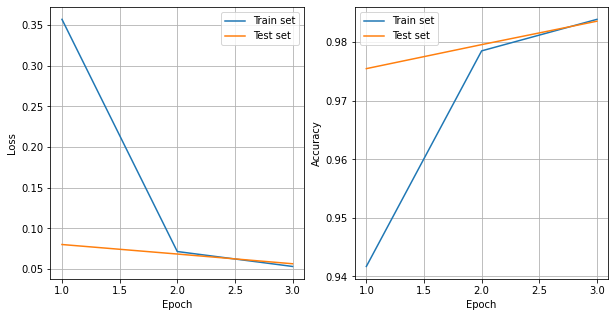

In [19]:
# Now we'll train the CNN model.
#
# Because the 2D architecture of the CNN constrains the model to learn patterns
# that exist in 2D space (e.g., nearby pixels are more likely to exhibit some
# connectedness/pattern than distant pixles) the model learns much more quickly
# (that is, with fewer training epochs). So we'll only train for 3 epochs this time.
# You can increase the number of epochs if you'd like.
#
# Also, the model expects the input samples to have a "channel" dimension, e.g.,
# three channels (red/green/blue) for color images, 1 channel for grayscale images.
# So we'll reshape our training images from (n_samples, 28, 28) to
# (n_samples, 28, 28, 1).
#
# Note that we used 'sparse_categorical_crossentropy' as the loss function,
# which is typical for classification tasks with a softmax output activation function.

cnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
n_epochs = 3
history = cnn_model.fit(x_train.reshape(-1, 28, 28 ,1), y_train, epochs=n_epochs,
                        validation_data=(x_test.reshape(-1, 28, 28 ,1), y_test))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_epochs+1), history.history['loss'], label='Train set')
plt.plot(np.arange(1, n_epochs+1), history.history['val_loss'], label='Test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, n_epochs+1), history.history['accuracy'], label='Train set')
plt.plot(np.arange(1, n_epochs+1), history.history['val_accuracy'], label='Test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
print(f"\nAccuracy on the final epoch of training was {100*history.history['accuracy'][-1]:0.2f}%")

In [20]:
# Let's assess our CNN model's performance on the test set
cnn_scores = cnn_model.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)

print(f"\nThe CNN model achieves an accuracy of {cnn_scores[1]*100:.2f}% on the test data.")

313/313 [==============================] - 3s 9ms/step - loss: 0.0565 - accuracy: 0.9836

The CNN model achieves an accuracy of 98.36% on the test data.


### Results from the CNN model

If all went as planned, you saw notably higher accuracy from the CNN than from the feedforward network, __despite both networks having the same number of layers and nearly the same number of model parameters. It also converged much faster!__

We didn't use dropout this time, so the "artificial" situation in which test set accuracy appears to be notably higher than training set accuracy should go away. However, even without dropout, the test set accuracy is often reported as being higher in *early* epochs, but this is for a different reason. The accuracy reported for a training set of a given epoch is the average of all batch accuracies *while the model was learning*, such that early batches did worse than later batches, within that epoch. The test set is not scored until after the training epoch is complete, so the model is "better" at that moment in time, and thus the test set accuracy score is higher.

__Feel free to modify the FF and/or CNN networks__ -- increasing or decreasing number of neurons, numbers of layers, and types of activation functions. __Just be sure that your asserts/test cells pass after a fresh run of your notebook, before turning it in.__

In [21]:
assert cnn_scores[1] > 0.9

### Play in the sandbox

Below you may want to explore the outputs of the two models for a variety of individual samples (images). With each run, the output predictions for all 10 classes are plotted, so you can __compare the "sharpness" of the predicted class probability distribution__ (using the term "probability distribution" loosely) of the CNN versus the FF model. 

1/1 [==============================] - 0s 78ms/step
Feedforward model predicts class 8.
        CNN model predicts class 8.


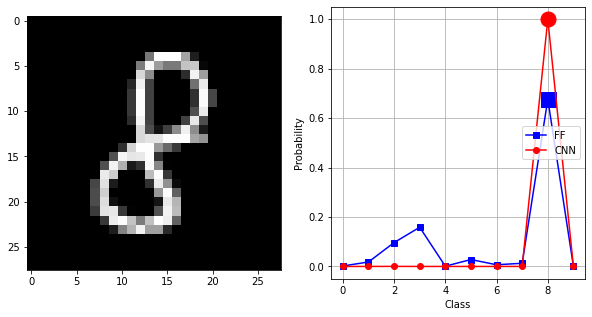

In [22]:
# Change this value to test out some samples, and see what
# them models' predictions look like.

i = 1961   # Pick any number from 0 to 9999

new_example = x_test[i]
ff_class_probabilities = ff_model.predict(new_example.reshape(-1, 28, 28))
ff_class_prediction = np.argmax(ff_class_probabilities)

cnn_class_probabilities = cnn_model.predict(new_example.reshape(-1, 28, 28, 1))
cnn_class_prediction = np.argmax(cnn_class_probabilities)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(new_example, cmap="gray")

plt.subplot(1, 2, 2)
plt.plot(ff_class_probabilities[0], '-bs', label='FF')
plt.plot(ff_class_prediction, np.max(ff_class_probabilities[0]), 'bs', markersize=15)
plt.plot(cnn_class_probabilities[0], '-ro', label='CNN')
plt.plot(cnn_class_prediction, np.max(cnn_class_probabilities[0]), 'ro', markersize=15)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.legend(loc='center right')
plt.grid(True)

print(f"Feedforward model predicts class {ff_class_prediction}.")
print(f"        CNN model predicts class {cnn_class_prediction}.")

## Feedback

In [23]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    # YOUR CODE HERE
    feedback = "This was fine. Took me a while to do."
    return feedback

In [24]:
feedback()

'This was fine. Took me a while to do.'